In [ ]:
import cv2
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from google.colab.patches import cv2_imshow
from tensorflow.keras.utils import Sequence

In [ ]:
CONFIG = {
    "img_size" : 256,
    "learning_rate" : 3e5,
    "batch_size" : 64,
}

In [ ]:
Root_dir = "/content/drive/MyDrive/학교/TNT/Thermal Dogs and People.v1-resize-416x416.multiclass"

In [ ]:
train_root = Root_dir + "/train"
train_label_root = train_root + "/_classes.csv"
valid_root = Root_dir + "/valid"
valid_label_root = valid_root + "/_classes.csv"
test_root = Root_dir + "/test"
test_label_root = test_root + "/_classes.csv"

In [ ]:
train_label = pd.read_csv(train_label_root)
train_label.columns = ['filename', 'dog', 'person']
valid_label = pd.read_csv(valid_label_root)
valid_label.columns = ['filename', 'dog', 'person']
test_label = pd.read_csv(test_label_root)
test_label.columns = ['filename', 'dog', 'person']

In [ ]:
def image_show(root,label,index):
    image = cv2.imread(root + "/" + os.listdir(root)[index])
    if label[label['filename'] == os.listdir(train_root)[index]]['dog'].iloc[0] == 1 :
        target_label = 'dog'
    else :
        target_label = 'person'      
    print(target_label)
    cv2_imshow(image)
    return

person


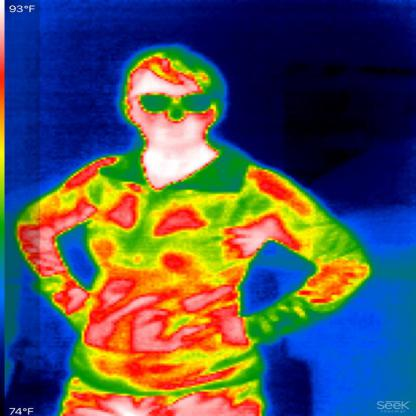

In [ ]:
image_show(train_root, train_label, 2)

In [ ]:
class_label = {
    0 : "dog",
    1 : "person"
}
num_classes = 2

In [ ]:
class Dataloader(Sequence):
    def __init__(self, data_root, label_csv, batch_size, IMG_SIZE,shuffle=False):
        self.label = label_csv
        self.x, self.y = self.prepare_data(data_root, label_csv)
        self.batch_size = batch_size
        self.img_size = IMG_SIZE
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_x = []
        batch_y = []        
        for i in indices:
            batch_x.append(tf.image.resize(self.x[i], [self.img_size, self.img_size]))
            batch_y.append(self.y[i])
        return np.array(batch_x), np.array(batch_y)

    def on_epoch_end(self):
        self.indices = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indices)
    
    def prepare_data(self, data_root, label_csv):
        x = []
        y = []
        for data in os.listdir(data_root):
            if data == "_classes.csv":
                pass
            else :
                img = cv2.imread(data_root + '/' + data)
                x.append(img)
                if self.label[self.label['filename'] == data]['dog'].iloc[0] == 1 :
                    target_label = 0
                else :
                    target_label = 1
                y.append(target_label)
        return x, y

In [ ]:
train_loader = Dataloader(train_root, train_label, batch_size = CONFIG['batch_size'], IMG_SIZE = CONFIG["img_size"], shuffle= True)
valid_loader = Dataloader(valid_root, valid_label, batch_size = CONFIG['batch_size'], IMG_SIZE = CONFIG["img_size"], shuffle= True)
test_loader = Dataloader(test_root, test_label, batch_size = 1, IMG_SIZE = CONFIG["img_size"])

In [ ]:
model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
def layer_block(input):
    x = layers.Conv2D(32, 3, activation='relu')(input)
    x = layers.MaxPooling2D()(x)
    return x
    
def make_model():
    inputs = tf.keras.layers.Input(shape = (CONFIG['img_size'], CONFIG['img_size'], 3))
    x = layers.experimental.preprocessing.Rescaling(1./255)(inputs)
    for i in range(3):
        x = layer_block(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation = 'softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

In [ ]:
model = make_model()

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
history = model.fit(train_loader,validation_data= valid_loader ,epochs = 10)

Epoch 1/10
3/3 [==============================] - 2s 455ms/step - loss: 0.8710 - accuracy: 0.6127 - val_loss: 0.8673 - val_accuracy: 0.4634
Epoch 2/10
3/3 [==============================] - 1s 221ms/step - loss: 0.7596 - accuracy: 0.5070 - val_loss: 0.5796 - val_accuracy: 0.6341
Epoch 3/10
3/3 [==============================] - 1s 220ms/step - loss: 0.6262 - accuracy: 0.6268 - val_loss: 0.5221 - val_accuracy: 0.8293
Epoch 4/10
3/3 [==============================] - 1s 219ms/step - loss: 0.4751 - accuracy: 0.8451 - val_loss: 0.4735 - val_accuracy: 0.8049
Epoch 5/10
3/3 [==============================] - 1s 220ms/step - loss: 0.3451 - accuracy: 0.8944 - val_loss: 0.3828 - val_accuracy: 0.8537
Epoch 6/10
3/3 [==============================] - 1s 221ms/step - loss: 0.2431 - accuracy: 0.9507 - val_loss: 0.5437 - val_accuracy: 0.8049
Epoch 7/10
3/3 [==============================] - 1s 219ms/step - loss: 0.2577 - accuracy: 0.9085 - val_loss: 0.4747 - val_accuracy: 0.7805
Epoch 8/10
3/3 [====

Prediction : person  |||   Label : person


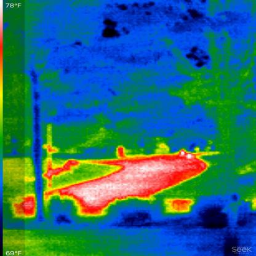

Prediction : dog  |||   Label : dog


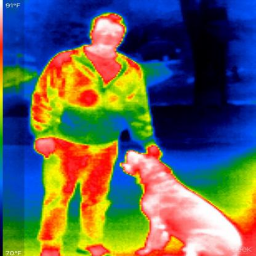

Prediction : person  |||   Label : person


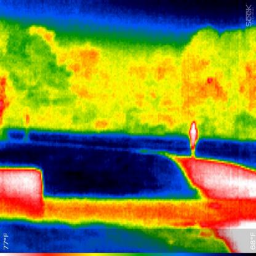

Prediction : dog  |||   Label : dog


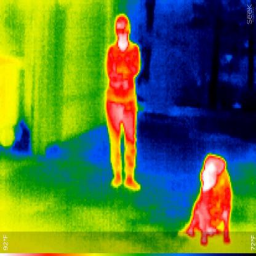

Prediction : person  |||   Label : dog


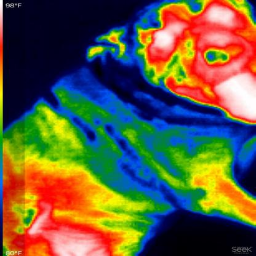

Prediction : person  |||   Label : dog


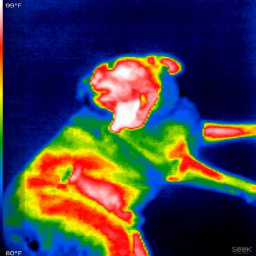

Prediction : person  |||   Label : person


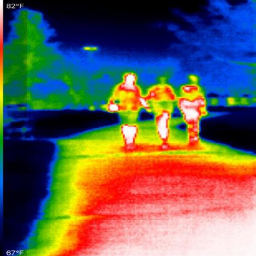

Prediction : dog  |||   Label : dog


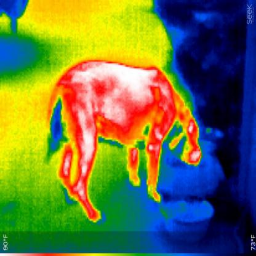

Prediction : person  |||   Label : person


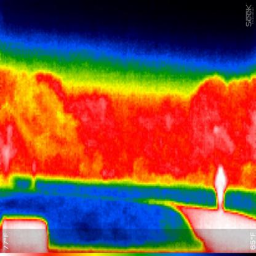

Prediction : person  |||   Label : person


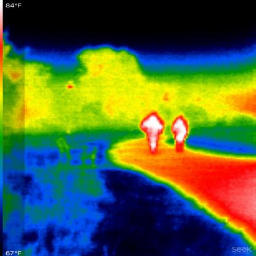

Prediction : dog  |||   Label : dog


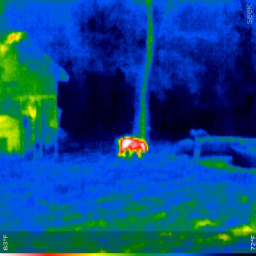

Prediction : person  |||   Label : person


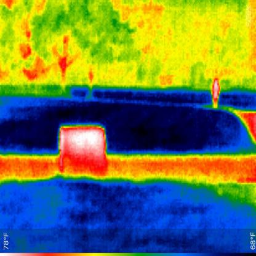

Prediction : dog  |||   Label : dog


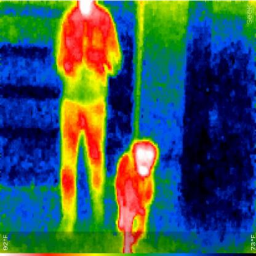

Prediction : dog  |||   Label : dog


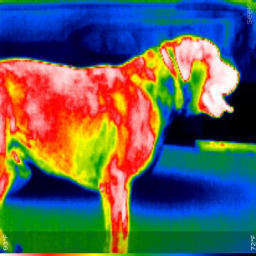

Prediction : person  |||   Label : person


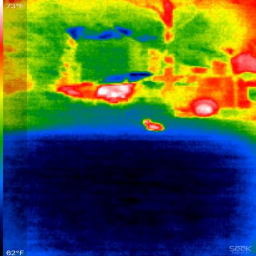

Prediction : person  |||   Label : person


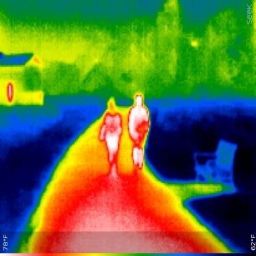

Prediction : person  |||   Label : person


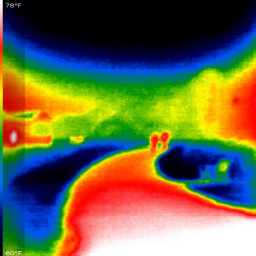

Prediction : dog  |||   Label : dog


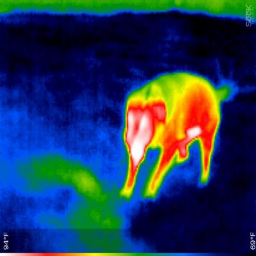

Prediction : dog  |||   Label : dog


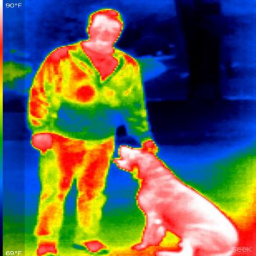

Prediction : dog  |||   Label : dog


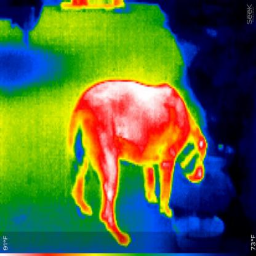

In [ ]:
for x, y in test_loader:
    print("="* 100)
    prediction = model(x).numpy().argmax()
    print("Prediction :", class_label[prediction], " |||   Label :", class_label[y[0]])
    cv2_imshow(x.squeeze())
    print("="* 100)